In [1]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 
from typing import Any, Optional, List

import qubx
from qubx import logger, lookup
from qubx.backtester.simulator import simulate
from qubx.core.metrics import tearsheet
from qubx.core.strategy import IStrategy, TriggerEvent, StrategyContext
from qubx.trackers import Capital, PortfolioRebalancerTracker
from qubx.core.basics import Instrument, Position, Signal

%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, QuestDBConnector, DataReader, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC, AsPandasFrame, RestoreTicksFromOHLC, AsOhlcvSeries
from qubx.pandaz.utils import *
from qubx.data.helpers import  InMemoryCachedReader, loader

 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


# Aux Data interface

In [20]:
r_csv = CsvStorageDataReader("../tests/data/csv")
r_mqc = MultiQdbConnector("xlydian-data")
r_qdb = QuestDBConnector(host="xlydian-data")

In [10]:
r_csv.get_aux_data_ids(), r_qdb.get_aux_data_ids(), r_mqc.get_aux_data_ids()

(set(),
 {'average_quote_volume', 'candles', 'fundamental_data', 'symbols'},
 {'average_quote_volume', 'candles', 'fundamental_data', 'symbols'})

In [ ]:
r_mqc.get_aux_data('candles', exchange='BINANCE.UM', 
                   symbols=['BTCUSDT', 'ETHUSDT'], 
                   start='2024-01-01', stop='2024-01-31')

In [26]:
r_qdb.get_aux_data('fundamental_data', exchange='BINANCE.UM', 
                #    symbols=['BTCUSDT', 'ETHUSDT'], 
                   start='2024-01-01', stop='2024-02-01')

metric                  market_cap       price        volume    volume_usd
timestamp  symbol                                                         
2024-01-01 1INCHUSDT  4.810212e+08     0.42810  2.528007e+07  1.082240e+07
           AAVEUSDT   1.604350e+09   108.78000  1.155772e+06  1.257249e+08
           ACHUSDT    1.051147e+08     0.02136  4.327358e+08  9.243236e+06
           ADAUSDT    2.076801e+10     0.59410  3.323489e+08  1.974485e+08
           AGIXUSDT   3.989788e+08     0.31970  4.189333e+07  1.339330e+07
...                            ...         ...           ...           ...
2024-01-31 YFIUSDT    2.435439e+08  7309.00000  1.259769e+03  9.207652e+06
           ZECUSDT    3.307871e+08    22.59000  5.673166e+05  1.281568e+07
           ZENUSDT    1.160340e+08     7.94800  5.515012e+05  4.383332e+06
           ZILUSDT    3.599965e+08     0.02046  3.587373e+08  7.339764e+06
           ZRXUSDT    2.798377e+08     0.33150  1.322362e+08  4.383631e+07

[5456 rows x 4 columns]

# Handy reader

In [72]:
r_mqc = MultiQdbConnector("xlydian-data")

In [73]:
F = '4h'
_P = lambda ds: [print(f"{s} : {len(v)} | {v.index[0]} : {v.index[-1]}") for s, v in ds.items()]
mcr = InMemoryCachedReader('BINANCE.UM', r_mqc, F)

In [29]:
mcr.read("BTCUSDT", "2020-01-01", "2024-08-10", transform=AsPandasFrame());

In [ ]:
mcr["ASTRUSDT", '2020-01-01':'2024-01-01'].close.plot()

In [ ]:
mcr["ASTRUSDT", '2020-01-01':'2025-01-01'].close.plot()

<Axes: xlabel='timestamp'>

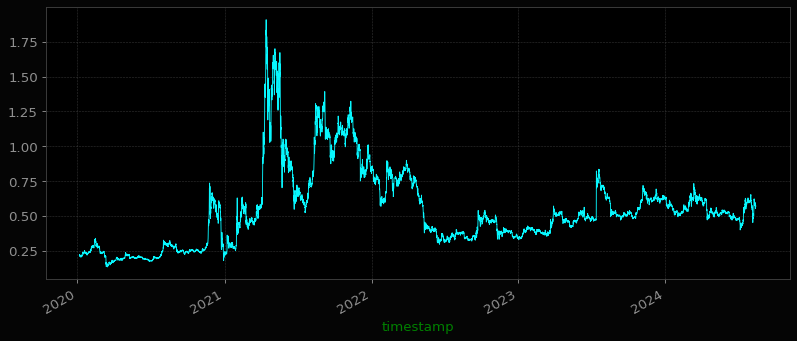

In [15]:
mcr["XRPUSDT", '2020-01-01':'2025-01-01'].close.plot()

In [ ]:
mcr.read("BTCUSDT", "2020-01-01", "2024-08-10", transform=AsPandasFrame())

In [ ]:
mcr["ATAUSDT"]

In [32]:
_P(mcr._get_symbols_from_to(['LTCUSDT', 'BTCUSDT'], "2023-01-01", "2024-01-01" ));

LTCUSDT : 2191 | 2023-01-01 00:00:00 : 2024-01-01 00:00:00
BTCUSDT : 2191 | 2023-01-01 00:00:00 : 2024-01-01 00:00:00


In [33]:
_P(mcr._get_symbols_from_to(['LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'XRPUSDT'], "2021-01-01", "2024-06-01" ));

LTCUSDT : 7453 | 2021-01-01 00:00:00 : 2024-06-01 00:00:00
BTCUSDT : 7459 | 2021-01-01 00:00:00 : 2024-06-01 00:00:00
ETHUSDT : 7483 | 2021-01-01 00:00:00 : 2024-06-01 00:00:00
SOLUSDT : 7453 | 2021-01-01 00:00:00 : 2024-06-01 00:00:00
XRPUSDT : 7453 | 2021-01-01 00:00:00 : 2024-06-01 00:00:00


In [86]:
"fff::c:/data".split("::")

['fff', 'c:/data']

In [ ]:
mcr1 = InMemoryCachedReader('BINANCE.UM', r_mqc, F)
_P(x1:=mcr1['LTCUSDT', "2021-01-01" : "2024-06-01"])
_P(x2:=mcr['LTCUSDT',  "2021-01-01" : "2024-06-01"])
all(x1==x2)

In [70]:
mcr["GALAUSDT", :'2023-01-01']

,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
timestamp,,,,,,,,,
2021-09-18 00:00:00,0.11358,0.12022,0.11148,0.11445,6.305044e+07,7351074.5,22840,26654140.0,3109883.2
2021-09-18 04:00:00,0.11442,0.11887,0.10412,0.10837,2.382351e+08,26215362.0,80628,109107784.0,12020291.0
2021-09-18 08:00:00,0.10837,0.11798,0.10440,0.11310,2.995232e+08,33087352.0,95557,140715968.0,15578291.0
2021-09-18 12:00:00,0.11319,0.13840,0.11272,0.13000,1.920679e+09,250446624.0,507988,974595710.0,127152928.0
2021-09-18 16:00:00,0.13000,0.13190,0.11319,0.11586,1.028713e+09,124677496.0,271595,498680224.0,60459776.0
...,...,...,...,...,...,...,...,...,...
2022-12-31 08:00:00,0.01640,0.01655,0.01632,0.01641,2.386384e+08,3919607.0,14892,118997912.0,1955452.8
2022-12-31 12:00:00,0.01640,0.01692,0.01633,0.01661,6.860614e+08,11443808.0,35514,356820256.0,5953916.0
2022-12-31 16:00:00,0.01661,0.01678,0.01649,0.01652,3.119849e+08,5189706.0,17815,146555328.0,2438995.5


# Loader with external custom data and time cut

Load external data

In [71]:
aux_all = pd.read_csv("../tests/data/csv/electricity_data.csv.gz", parse_dates=['datetime'])
electro_aux = aux_all[(aux_all['stateDescription'] == 'U.S. Total') & (aux_all['sectorName']=='all sectors')].set_index("datetime", drop=True)

In [77]:
class _FixTimeProvider:
    def time(self) -> np.datetime64: 
        return np.datetime64("2022-06-01 05:00")

ldr = loader(
    "BINANCE.UM", '1h', 
    electro=electro_aux,
    source="csv::../tests/data/csv/", 
    # source="mqdb::xlydian-data", 
    time_provider=_FixTimeProvider()
)

In [78]:
ldr.read('BTCUSDT', '2010-01-01', '2025-01-01')[-10:]

ValueError: CsvStorageDataReader doesn't have getter for 'candles' auxiliary data. Available data: set()

In [79]:
ldr.get_aux_data_ids()

{'electro'}

In [ ]:
ldr['BTCUSDT', '2019-01-01':'2025-01-01']

In [ ]:
ldr.get_aux_data('candles', symbols=['SOLUSDT', 'ETHUSDT'], start='2020-01-01', stop='2025-01-01')

In [ ]:
ldr.get_aux_data("fundamental_data", start="2020-01-01", stop="2025-01-01")

# Test in strategy

In [39]:
class Tester(IStrategy):
    exchange: str = "BINANCE.UM"
    min_capitalization_mil: float = 400
    # hist_reader: MultiQdbConnector | None = None

    def on_start(self, ctx: StrategyContext):
        f_data = ctx.get_aux_data("fundamental_data", None, '1d', "2020-01-01")
        print(f_data)

    def on_fit(
        self, ctx: StrategyContext, fit_time: str | pd.Timestamp, previous_fit_time: str | pd.Timestamp | None = None
    ):
        stop = pd.Timestamp(fit_time)
        start = stop - pd.Timedelta('5d')  # type: ignore
        logger.info(f"Fitting on data range: {start} : {stop}")
        # fundamental = self.hist_reader.get_fundamental_data(self.exchange, start, stop)

        # _last_caps = pd.Series(fundamental["market_cap"].groupby("symbol").last().to_dict())
        # _last_caps = _last_caps[_last_caps >= self.min_capitalization_mil * 1e6]
        # symbols_available = set(_last_caps.index)
        # raw_data = self.hist_reader.get_candles(
        #     self.exchange, list(symbols_available), start, stop, '1d'
        # )
        # logger.info(str(raw_data.head()))

    def on_event(self, ctx: StrategyContext, event: TriggerEvent) -> List[Signal] | None:
        logger.info(f"Event: {ctx.time()}")
        return None


In [45]:
rd = loader("BINANCE.UM", '1h', source="mqdb::xlydian-data", n_jobs=1)

In [50]:
rd['BTCUSDT', '2020-01-01':'2021-01-01']

,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
timestamp,,,,,,,,,
2020-01-01 00:00:00,7189.43,7190.52,7170.15,7171.55,2449.049,17576424.0,3688,996.198,7149371.0
2020-01-01 01:00:00,7171.43,7225.00,7171.10,7210.24,3865.038,27838048.0,6635,2340.879,16860294.0
2020-01-01 02:00:00,7210.38,7239.30,7206.46,7237.99,3228.365,23324808.0,5120,1774.145,12818472.0
2020-01-01 03:00:00,7237.41,7239.74,7215.00,7221.65,2513.307,18161820.0,4143,1245.065,8996219.0
2020-01-01 04:00:00,7221.80,7225.41,7211.22,7213.86,1176.666,8493631.0,1966,586.864,4236085.0
...,...,...,...,...,...,...,...,...,...
2020-12-31 20:00:00,28917.08,29180.99,28888.00,29155.97,5985.124,173600592.0,53077,3132.339,90888720.0
2020-12-31 21:00:00,29155.96,29199.49,28915.96,28990.83,7883.537,229179792.0,65760,3724.889,108304544.0
2020-12-31 22:00:00,28993.77,29175.92,28920.07,29125.25,4290.432,124766688.0,47491,1949.491,56697968.0


In [ ]:
r = simulate({ 'mtx0': Tester(min_capitalization_mil=400) },
    rd,
    capital=100000, instruments=["BINANCE.UM:BTCUSDT"], commissions="vip0_usdt",
    trigger="1d -5Min", 
    subscription=dict(type="ohlc", timeframe='1h', nback=14*24),
    fit='50 23 * */2 L7', # last Sun each 3'rd month
    start="2023-01-01 00:00", stop="2024-01-10",
    debug="DEBUG", 
    # enable_event_batching=True
)